In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.9 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn

Number of data samples in the dataset: 600
Number of features per node: 3
Number of classes: 6
Current Timestamp: 2024-11-20 22:37:29
Epoch: 010, Train Loss: 1.7118, Val AUC: 0.5733, Test AUC: 0.5943
Epoch: 020, Train Loss: 1.6885, Val AUC: 0.5780, Test AUC: 0.6267
Epoch: 030, Train Loss: 1.6109, Val AUC: 0.5963, Test AUC: 0.6753
Epoch: 040, Train Loss: 1.6097, Val AUC: 0.6377, Test AUC: 0.6933
Epoch: 050, Train Loss: 1.6152, Val AUC: 0.6160, Test AUC: 0.6750
Epoch: 060, Train Loss: 1.6408, Val AUC: 0.5957, Test AUC: 0.6973
Epoch: 070, Train Loss: 1.5980, Val AUC: 0.6177, Test AUC: 0.6810
Epoch: 080, Train Loss: 1.5872, Val AUC: 0.6260, Test AUC: 0.6903
Epoch: 090, Train Loss: 1.5674, Val AUC: 0.6443, Test AUC: 0.7210
Epoch: 100, Train Loss: 1.5183, Val AUC: 0.6083, Test AUC: 0.6980
Epoch: 110, Train Loss: 1.5907, Val AUC: 0.6053, Test AUC: 0.7080
Epoch: 120, Train Loss: 1.5490, Val AUC: 0.6307, Test AUC: 0.7277
Epoch: 130, Train Loss: 1.5519, Val AUC: 0.5987, Test AUC: 0.6993
Epoch: 1

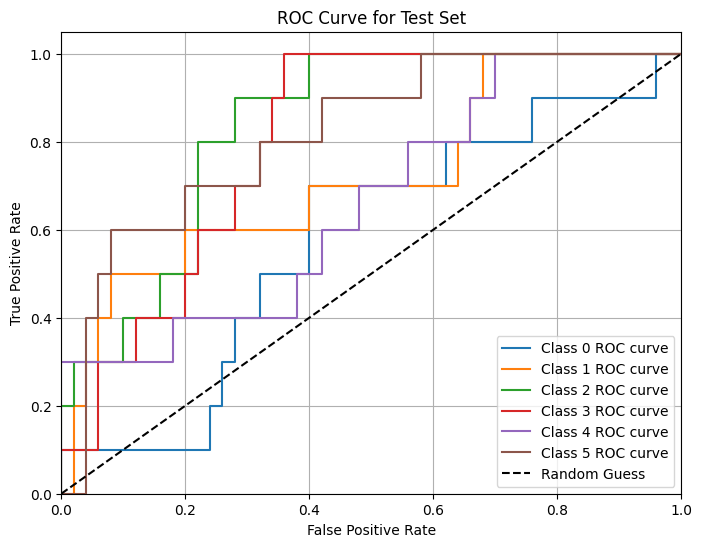

In [ ]:
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool
from torch.nn import BatchNorm1d
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import pytz
from datetime import datetime
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")


# Load the ENZYMES dataset
dataset = TUDataset(root='data/ENZYMES', name='ENZYMES', transform=NormalizeFeatures())
num_classes = dataset.num_classes

print(f"Number of data samples in the dataset: {len(dataset)}")
print(f"Number of features per node: {dataset.num_features}")
print(f"Number of classes: {num_classes}")

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define 1-layer GCN Model with Batch Normalization
class GCN1(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN1, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply Batch Normalization
        x = F.relu(x)
        x = pyg_nn.global_max_pool(x, data.batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Split dataset into 70% train, 15% validation, and 15% test
labels = dataset.data.y.numpy()
train_indices, temp_indices = train_test_split(
    range(len(dataset)), stratify=labels, test_size=0.2, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, stratify=[labels[i] for i in temp_indices], test_size=0.5, random_state=42
)

# Create new train, validation, and test datasets based on the split
train_dataset = DataLoader([dataset[i] for i in train_indices], batch_size=32, shuffle=True)
val_dataset = DataLoader([dataset[i] for i in val_indices], batch_size=32, shuffle=False)
test_dataset = DataLoader([dataset[i] for i in test_indices], batch_size=32, shuffle=False)

# Initialize model
model = GCN1(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
class_weights = torch.tensor(compute_class_weight(
    'balanced', classes=np.unique(labels), y=labels), dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
#criterion = torch.nn.CrossEntropyLoss()

# Train function
def train():
    model.train()
    total_loss = 0
    for data in train_dataset:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_dataset)

# Validation/Test function
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.softmax(dim=1).detach().cpu()  # Probabilities for AUC
        all_preds.append(pred)
        all_labels.append(data.y.cpu())
    return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)

# Compute AUC (only when multiple classes are present)
def compute_auc(y_true, y_score, num_classes):
    unique_classes = torch.unique(y_true)
    if len(unique_classes) == 1:  # Only one class in the batch
        return None
    y_true_one_hot = F.one_hot(y_true, num_classes=num_classes).numpy()
    try:
        auc = roc_auc_score(y_true_one_hot, y_score.numpy(), multi_class='ovr')
        return auc
    except ValueError as e:
        print(f"AUC computation error: {e}")
        return None

# Cincinnati timestamp
cincinnati_tz = pytz.timezone('America/New_York')
cincinnati_time = datetime.now(cincinnati_tz)
print("Current Timestamp:", cincinnati_time.strftime('%Y-%m-%d %H:%M:%S'))

# Training and Evaluation Loop
num_epochs = 300
for epoch in range(1, num_epochs + 1):
    # Training Step
    train_loss = train()

    # Evaluate on Validation and Test sets
    val_preds, val_labels = evaluate(val_dataset)
    test_preds, test_labels = evaluate(test_dataset)

    # Compute AUC for Validation and Test Sets
    val_auc = compute_auc(val_labels, val_preds, num_classes=dataset.num_classes)
    test_auc = compute_auc(test_labels, test_preds, num_classes=dataset.num_classes)

    # Print results every 10 epochs
    if epoch % 10 == 0:
        val_auc_text = f'{val_auc:.4f}' if val_auc is not None else 'Unavailable'
        test_auc_text = f'{test_auc:.4f}' if test_auc is not None else 'Unavailable'
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val AUC: {val_auc_text}, Test AUC: {test_auc_text}')

# Compute ROC curve for the test dataset
def plot_roc_curve(y_true, y_score, num_classes):
    """Plots the ROC curve for multi-class classification."""
    # Binarize the true labels
    y_true_bin = label_binarize(y_true.numpy(), classes=list(range(num_classes)))

    # Calculate ROC curve for each class
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i].numpy())

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Test Set')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Final Evaluation
test_preds, test_labels = evaluate(test_dataset)
test_accuracy = accuracy_score(test_labels.numpy(), torch.argmax(test_preds, dim=1).numpy())
test_f1 = f1_score(test_labels.numpy(), torch.argmax(test_preds, dim=1).numpy(), average='macro')
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plot the ROC curve
plot_roc_curve(test_labels, test_preds, num_classes=dataset.num_classes)

In [ ]:
# Save model weights
from google.colab import files

weights_path = "gcn1_weights.pth"

torch.save(model.state_dict(), weights_path)
print(f"Weights saved as {weights_path}")

files.download(weights_path)


Weights saved as gcn1_weights.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Current Timestamp: 2024-11-20 22:19:50
Epoch: 010, Train Loss: 1.7406, Val AUC: 0.6670, Test AUC: 0.6827
Epoch: 020, Train Loss: 1.5955, Val AUC: 0.6277, Test AUC: 0.7320
Epoch: 030, Train Loss: 1.5759, Val AUC: 0.6490, Test AUC: 0.6687
Epoch: 040, Train Loss: 1.4734, Val AUC: 0.7023, Test AUC: 0.7797
Epoch: 050, Train Loss: 1.4076, Val AUC: 0.6883, Test AUC: 0.7637
Epoch: 060, Train Loss: 1.2726, Val AUC: 0.6817, Test AUC: 0.7693
Epoch: 070, Train Loss: 1.2410, Val AUC: 0.6637, Test AUC: 0.7153
Epoch: 080, Train Loss: 1.1811, Val AUC: 0.7077, Test AUC: 0.7440
Epoch: 090, Train Loss: 1.0822, Val AUC: 0.7043, Test AUC: 0.7610
Epoch: 100, Train Loss: 0.9398, Val AUC: 0.6497, Test AUC: 0.7773
Epoch: 110, Train Loss: 0.9630, Val AUC: 0.6900, Test AUC: 0.7877
Epoch: 120, Train Loss: 0.8401, Val AUC: 0.6803, Test AUC: 0.7270
Epoch: 130, Train Loss: 0.8768, Val AUC: 0.6873, Test AUC: 0.7063
Epoch: 140, Train Loss: 0.6963, Val AUC: 0.6987, Test AUC: 0.7713
Epoch: 150, Train Loss: 0.6438, Val A

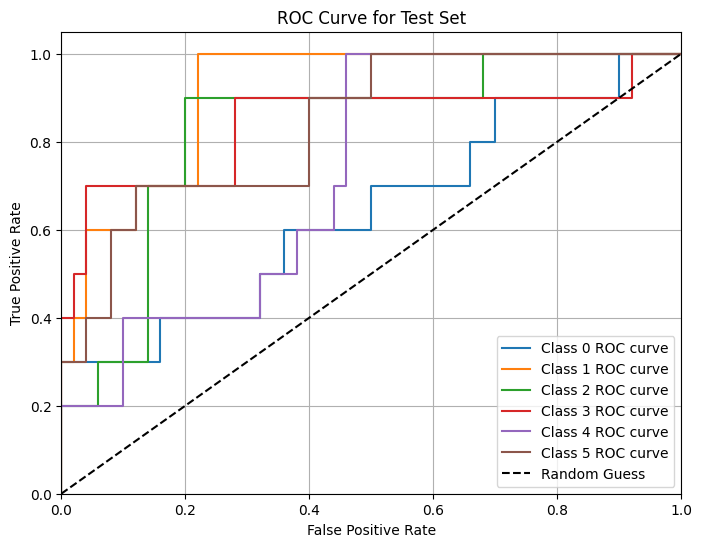

In [ ]:
# Define 2-layer GCN Model with Batch Normalization
class GCN2(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN2, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply Batch Normalization
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Apply Batch Normalization
        x = F.relu(x)
        x = pyg_nn.global_max_pool(x, data.batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Split dataset into 70% train, 15% validation, and 15% test
labels = dataset.data.y.numpy()
train_indices, temp_indices = train_test_split(
    range(len(dataset)), stratify=labels, test_size=0.2, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, stratify=[labels[i] for i in temp_indices], test_size=0.5, random_state=42
)

# Create new train, validation, and test datasets based on the split
train_dataset = DataLoader([dataset[i] for i in train_indices], batch_size=32, shuffle=True)
val_dataset = DataLoader([dataset[i] for i in val_indices], batch_size=32, shuffle=False)
test_dataset = DataLoader([dataset[i] for i in test_indices], batch_size=32, shuffle=False)

# Initialize model
model = GCN2(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
class_weights = torch.tensor(compute_class_weight(
    'balanced', classes=np.unique(labels), y=labels), dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Train function
def train():
    model.train()
    total_loss = 0
    for data in train_dataset:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_dataset)

# Validation/Test function
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.softmax(dim=1).detach().cpu()  # Probabilities for AUC
        all_preds.append(pred)
        all_labels.append(data.y.cpu())
    return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)

# Compute AUC (only when multiple classes are present)
def compute_auc(y_true, y_score, num_classes):
    unique_classes = torch.unique(y_true)
    if len(unique_classes) == 1:  # Only one class in the batch
        return None
    y_true_one_hot = F.one_hot(y_true, num_classes=num_classes).numpy()
    try:
        auc = roc_auc_score(y_true_one_hot, y_score.numpy(), multi_class='ovr')
        return auc
    except ValueError as e:
        print(f"AUC computation error: {e}")
        return None

# Cincinnati timestamp
cincinnati_tz = pytz.timezone('America/New_York')
cincinnati_time = datetime.now(cincinnati_tz)
print("Current Timestamp:", cincinnati_time.strftime('%Y-%m-%d %H:%M:%S'))

# Training and Evaluation Loop
num_epochs = 300
for epoch in range(1, num_epochs + 1):
    # Training Step
    train_loss = train()

    # Evaluate on Validation and Test sets
    val_preds, val_labels = evaluate(val_dataset)
    test_preds, test_labels = evaluate(test_dataset)

    # Compute AUC for Validation and Test Sets
    val_auc = compute_auc(val_labels, val_preds, num_classes=dataset.num_classes)
    test_auc = compute_auc(test_labels, test_preds, num_classes=dataset.num_classes)

    # Print results every 10 epochs
    if epoch % 10 == 0:
        val_auc_text = f'{val_auc:.4f}' if val_auc is not None else 'Unavailable'
        test_auc_text = f'{test_auc:.4f}' if test_auc is not None else 'Unavailable'
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val AUC: {val_auc_text}, Test AUC: {test_auc_text}')

# Compute ROC curve for the test dataset
def plot_roc_curve(y_true, y_score, num_classes):
    """Plots the ROC curve for multi-class classification."""
    # Binarize the true labels
    y_true_bin = label_binarize(y_true.numpy(), classes=list(range(num_classes)))

    # Calculate ROC curve for each class
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i].numpy())

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Test Set')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Final Evaluation
test_preds, test_labels = evaluate(test_dataset)
test_accuracy = accuracy_score(test_labels.numpy(), torch.argmax(test_preds, dim=1).numpy())
test_f1 = f1_score(test_labels.numpy(), torch.argmax(test_preds, dim=1).numpy(), average='macro')
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plot the ROC curve
plot_roc_curve(test_labels, test_preds, num_classes=dataset.num_classes)


In [ ]:
# Save model weights
from google.colab import files

weights_path = "gcn2_weights.pth"

torch.save(model.state_dict(), weights_path)
print(f"Weights saved as {weights_path}")

files.download(weights_path)

Weights saved as gcn2_weights.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Current Timestamp: 2024-11-20 22:40:46
Epoch: 010, Train Loss: 1.5790, Val AUC: 0.6343, Test AUC: 0.7507
Epoch: 020, Train Loss: 1.5037, Val AUC: 0.6057, Test AUC: 0.7147
Epoch: 030, Train Loss: 1.3993, Val AUC: 0.6483, Test AUC: 0.7540
Epoch: 040, Train Loss: 1.3200, Val AUC: 0.5860, Test AUC: 0.6803
Epoch: 050, Train Loss: 1.1787, Val AUC: 0.6900, Test AUC: 0.7613
Epoch: 060, Train Loss: 1.1243, Val AUC: 0.6460, Test AUC: 0.6967
Epoch: 070, Train Loss: 0.9575, Val AUC: 0.7550, Test AUC: 0.7620
Epoch: 080, Train Loss: 0.8835, Val AUC: 0.7357, Test AUC: 0.7920
Epoch: 090, Train Loss: 0.7546, Val AUC: 0.6860, Test AUC: 0.7503
Epoch: 100, Train Loss: 0.7286, Val AUC: 0.6843, Test AUC: 0.7703
Epoch: 110, Train Loss: 0.4845, Val AUC: 0.6763, Test AUC: 0.7507
Epoch: 120, Train Loss: 0.4626, Val AUC: 0.6370, Test AUC: 0.6800
Epoch: 130, Train Loss: 0.4436, Val AUC: 0.7963, Test AUC: 0.7870
Epoch: 140, Train Loss: 0.4274, Val AUC: 0.7583, Test AUC: 0.8033
Epoch: 150, Train Loss: 0.3193, Val A

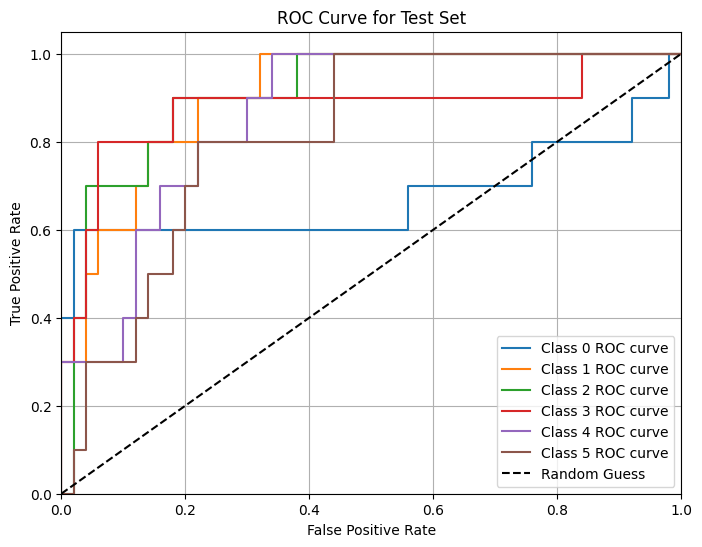

In [ ]:
# Define 3-layer GCN Model with Batch Normalization
class GCN3(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN3, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply Batch Normalization
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Apply Batch Normalization
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)  # Apply Batch Normalization
        x = F.relu(x)
        x = pyg_nn.global_max_pool(x, data.batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Split dataset into 70% train, 15% validation, and 15% test
labels = dataset.data.y.numpy()
train_indices, temp_indices = train_test_split(
    range(len(dataset)), stratify=labels, test_size=0.2, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, stratify=[labels[i] for i in temp_indices], test_size=0.5, random_state=42
)

# Create new train, validation, and test datasets based on the split
train_dataset = DataLoader([dataset[i] for i in train_indices], batch_size=32, shuffle=True)
val_dataset = DataLoader([dataset[i] for i in val_indices], batch_size=32, shuffle=False)
test_dataset = DataLoader([dataset[i] for i in test_indices], batch_size=32, shuffle=False)

# Initialize model
model = GCN3(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
class_weights = torch.tensor(compute_class_weight(
    'balanced', classes=np.unique(labels), y=labels), dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Train function
def train():
    model.train()
    total_loss = 0
    for data in train_dataset:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_dataset)

# Validation/Test function
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.softmax(dim=1).detach().cpu()  # Probabilities for AUC
        all_preds.append(pred)
        all_labels.append(data.y.cpu())
    return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)

# Compute AUC (only when multiple classes are present)
def compute_auc(y_true, y_score, num_classes):
    unique_classes = torch.unique(y_true)
    if len(unique_classes) == 1:  # Only one class in the batch
        return None
    y_true_one_hot = F.one_hot(y_true, num_classes=num_classes).numpy()
    try:
        auc = roc_auc_score(y_true_one_hot, y_score.numpy(), multi_class='ovr')
        return auc
    except ValueError as e:
        print(f"AUC computation error: {e}")
        return None

# Cincinnati timestamp
cincinnati_tz = pytz.timezone('America/New_York')
cincinnati_time = datetime.now(cincinnati_tz)
print("Current Timestamp:", cincinnati_time.strftime('%Y-%m-%d %H:%M:%S'))

# Training and Evaluation Loop
num_epochs = 300
for epoch in range(1, num_epochs + 1):
    # Training Step
    train_loss = train()

    # Evaluate on Validation and Test sets
    val_preds, val_labels = evaluate(val_dataset)
    test_preds, test_labels = evaluate(test_dataset)

    # Compute AUC for Validation and Test Sets
    val_auc = compute_auc(val_labels, val_preds, num_classes=dataset.num_classes)
    test_auc = compute_auc(test_labels, test_preds, num_classes=dataset.num_classes)

    # Print results every 10 epochs
    if epoch % 10 == 0:
        val_auc_text = f'{val_auc:.4f}' if val_auc is not None else 'Unavailable'
        test_auc_text = f'{test_auc:.4f}' if test_auc is not None else 'Unavailable'
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val AUC: {val_auc_text}, Test AUC: {test_auc_text}')

# Compute ROC curve for the test dataset
def plot_roc_curve(y_true, y_score, num_classes):
    """Plots the ROC curve for multi-class classification."""
    # Binarize the true labels
    y_true_bin = label_binarize(y_true.numpy(), classes=list(range(num_classes)))

    # Calculate ROC curve for each class
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i].numpy())

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Test Set')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Final Evaluation
test_preds, test_labels = evaluate(test_dataset)
test_accuracy = accuracy_score(test_labels.numpy(), torch.argmax(test_preds, dim=1).numpy())
test_f1 = f1_score(test_labels.numpy(), torch.argmax(test_preds, dim=1).numpy(), average='macro')
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plot the ROC curve
plot_roc_curve(test_labels, test_preds, num_classes=dataset.num_classes)


In [ ]:
# Save model weights
from google.colab import files

weights_path = "gcn3_weights.pth"

torch.save(model.state_dict(), weights_path)
print(f"Weights saved as {weights_path}")

files.download(weights_path)

Weights saved as gcn3_weights.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>